In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'ts', 'l1', 'l2', 'label']

train = pd.read_csv("/kaggle/input/russian-ai-olympiad-2023-b/Click-Prediction/train.tsv", sep='\t', usecols=cols)
test = pd.read_csv("/kaggle/input/russian-ai-olympiad-2023-b/Click-Prediction/test.tsv", sep='\t', usecols=cols[:-1])

In [3]:
for col in train.select_dtypes(include='float64').columns:
    train[col] = pd.to_numeric(train[col], downcast='float')

for col in test.select_dtypes(include='float64').columns:
    test[col] = pd.to_numeric(test[col], downcast='float')

In [4]:
# train = train.head(-1)
# test = test.head(-1)

train.drop(train.index[-1], axis=0, inplace=True)
test.drop(test.index[-1], axis=0, inplace=True)

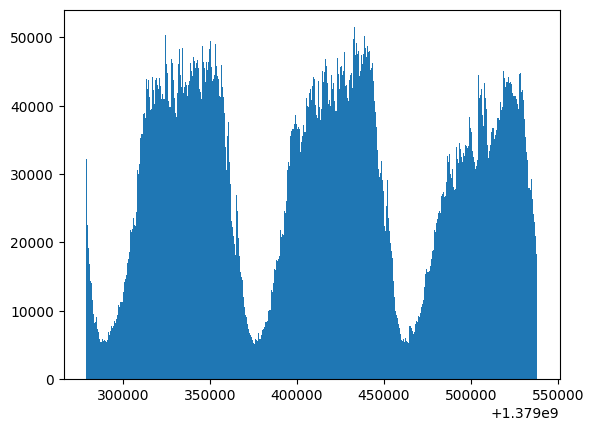

In [5]:
plt.hist(train['ts'], bins=1000)
plt.show()

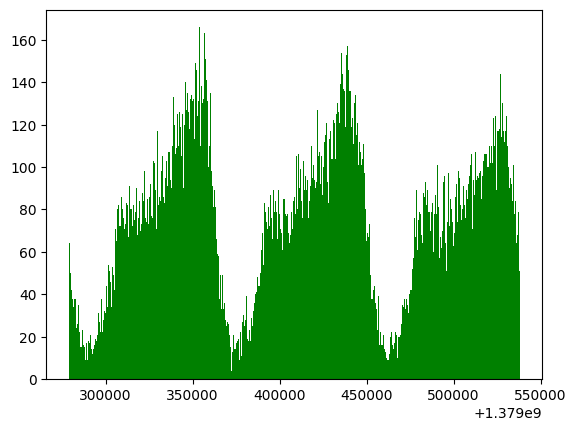

In [6]:
plt.hist(train[train['label']==1.0]['ts'], bins=1000, color='g')
plt.show()

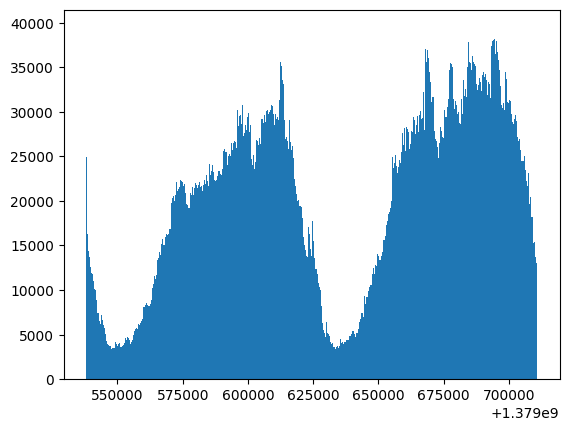

In [7]:
plt.hist(test['ts'], bins=1000)
plt.show()

In [8]:
def prepare_df(df):
    counts, bins = np.histogram(df['ts'], bins=1000)
    idxs = np.clip(np.searchsorted(bins, df['ts'], side='right')-1, 0, len(counts)-1)
    df['neighbours'] = counts[idxs]
    return df

In [9]:
train = prepare_df(train)
test = prepare_df(test)

In [11]:
from sklearn.model_selection import train_test_split

features = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'neighbours',
            'l1', 'l2']

X, y = train[features], train['label']
X_test = test[features]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=42, test_size=0.1)

In [13]:
from catboost import Pool

train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

In [14]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    loss_function='Logloss',
    iterations=30,
    metric_period=5,
    eval_metric='Logloss',
    max_depth=2
)

model.fit(train_pool, eval_set=valid_pool)

Learning rate set to 0.5
0:	learn: 0.3153267	test: 0.3171702	best: 0.3171702 (0)	total: 2.17s	remaining: 1m 3s
5:	learn: 0.0322904	test: 0.0320129	best: 0.0320129 (5)	total: 8.68s	remaining: 34.7s
10:	learn: 0.0169168	test: 0.0170998	best: 0.0170998 (10)	total: 14.7s	remaining: 25.4s
15:	learn: 0.0163669	test: 0.0162933	best: 0.0162933 (15)	total: 20.4s	remaining: 17.9s
20:	learn: 0.0159566	test: 0.0160759	best: 0.0160759 (20)	total: 26.3s	remaining: 11.3s
25:	learn: 0.0157596	test: 0.0158656	best: 0.0158656 (25)	total: 32.3s	remaining: 4.97s
29:	learn: 0.0156381	test: 0.0157448	best: 0.0157448 (29)	total: 36.9s	remaining: 0us

bestTest = 0.01574484509
bestIteration = 29



In [27]:
predictions = model.predict_proba(X_test)[:, 1].astype(np.float32)
predictions = np.round(predictions, 4)

subm = pd.DataFrame({
    'target': predictions
})

subm.head()

,target
0,0.0016
1,0.0008
2,0.0005
3,0.0052
4,0.0005


In [28]:
import zipfile

subm.to_csv("submission.csv", index=False)

with zipfile.ZipFile("submission.zip", 'w') as zip_ref:
    zip_ref.write('submission.csv')